In [4]:
# pip install torch torchvision

In [5]:
# pip install wandb

wandb: Appending key for api.wandb.ai to your netrc file: /Users/malakyehia/.netrc


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import wandb


In [8]:
class ConvBNActivation(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, groups=1, activation=nn.ReLU6):
        padding = (kernel_size - 1) // 2
        super().__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_channels),
            activation(inplace=True)
        )

In [57]:
class InvertedResidualBlock(nn.Module):
    def __init__(self, inp, outp, stride, expand_ratio, kernel_size=3, activation=nn.ReLU6):
        super().__init__()
        self.stride = stride
        hidden_dim = int(inp * expand_ratio)
        self.use_shortcut = stride == 1 and inp == outp
        
        layers = []
        if expand_ratio != 1:
            layers.append(ConvBNActivation(inp, hidden_dim, kernel_size=1, activation=activation))
        layers += [
            ConvBNActivation(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim, activation=activation, kernel_size=kernel_size),
            nn.Conv2d(hidden_dim, outp, 1, 1, 0, bias=False),
            nn.BatchNorm2d(outp),
        ]
        self.conv_layers = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_shortcut:
            return x + self.conv_layers(x)
        else:
            return self.conv_layers(x)



In [31]:
class CustomMobileNetV2(nn.Module):
    def __init__(self, num_classes, inverted_block_configs, first_layer_channels, expansion_layer_channels, dropout_rate=0.0, activation=nn.ReLU6):
        super().__init__()
        self.first_layer = ConvBNActivation(3, first_layer_channels, stride=2, activation=activation)
        self.inverted_blocks = nn.Sequential(
            *[InvertedResidualBlock(**cfg, activation=activation) for cfg in inverted_block_configs]
        )
        self.expansion_layer = ConvBNActivation(inverted_block_configs[-1]['outp'], expansion_layer_channels, kernel_size=1, activation=activation)
        self.dropout = nn.Dropout(p=dropout_rate)
        
        self.classifier = None
        self.num_classes = num_classes
        self._initialize_classifier(first_layer_channels, expansion_layer_channels, activation)

    def _initialize_classifier(self, first_layer_channels, expansion_layer_channels, activation):
        with torch.no_grad():
            dummy_input = torch.zeros(2, 3, 32, 32)  
            x = self.first_layer(dummy_input)
            x = self.inverted_blocks(x)
            x = self.expansion_layer(x)
            x = x.view(x.size(0), -1)
            output_size = x.shape[1]
      
        self.classifier = nn.Linear(output_size, self.num_classes)


    def forward(self, x):
        if self.classifier is None:
            raise RuntimeError("Classifier has not been initialized.")
        x = self.first_layer(x)
        x = self.inverted_blocks(x)
        x = self.expansion_layer(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x) 
        x = self.classifier(x)
        return x



In [11]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [12]:
def imshow_with_labels(images, labels, predictions=None):
    images = torchvision.utils.make_grid(images)  
    images = images / 2 + 0.5  # unnormalize
    np_images = images.numpy()
    plt.imshow(np.transpose(np_images, (1, 2, 0)))
    title = 'True: ' + ' '.join(f'{classes[labels[j]]}' for j in range(4))
    if predictions is not None:
        title += '\nPred: ' + ' '.join(f'{classes[predictions[j]]}' for j in range(4))
    plt.title(title)
    plt.show()


In [13]:
def train_model(model, device, train_loader, optimizer, epoch, train_losses, train_accuracy):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        correct += predicted.eq(target.view_as(predicted)).sum().item()
        total += target.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    train_losses.append(avg_loss)
    train_accuracy.append(accuracy)

    print(f'Train Epoch: {epoch}\tLoss: {avg_loss:.6f}, Accuracy: {accuracy:.2f}%')
    wandb.log({"train_loss": avg_loss, "train_accuracy": accuracy, "epoch": epoch})


In [14]:
def evaluate_model(model, device, data_loader, epoch, eval_losses, eval_accuracy):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = nn.CrossEntropyLoss()(output, target)
            total_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct += predicted.eq(target.view_as(predicted)).sum().item()
            total += target.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = 100. * correct / total
    eval_losses.append(avg_loss)
    eval_accuracy.append(accuracy)

    print(f'Eval Epoch: {epoch}\tLoss: {avg_loss:.6f}, Accuracy: {accuracy:.2f}%')
    wandb.log({"eval_loss": avg_loss, "eval_accuracy": accuracy, "epoch": epoch})


In [15]:
def plot_metrics(train_losses, train_accuracy, eval_losses, eval_accuracy):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    axs[0, 0].plot(train_losses, label="Training Loss")
    axs[0, 0].set_title("Training Loss")

    axs[0, 1].plot(train_accuracy, label="Training Accuracy")
    axs[0, 1].set_title("Training Accuracy")

    axs[1, 0].plot(eval_losses, label="Evaluation Loss")
    axs[1, 0].set_title("Evaluation Loss")

    axs[1, 1].plot(eval_accuracy, label="Evaluation Accuracy")
    axs[1, 1].set_title("Evaluation Accuracy")

    plt.show()

In [16]:
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
device

device(type='mps')

In [17]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
cifar10_dataset = torchvision.datasets.CIFAR10(root='./data', download=True, train=True, transform=transform)


Files already downloaded and verified


In [48]:
def main(model, config, cifar10_dataset, exp_name):
    with wandb.init(project="mobilenetv2_experiments2", config=config, name=exp_name) as run:
        device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
        model = model.to(device)
        print(device)
        if config["optimizer"] == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
        
        scheduler = StepLR(optimizer, step_size=config["scheduler_step_size"], gamma= config['scheduler_gamma'])
        
        train_loader = DataLoader(cifar10_dataset, batch_size=config["batch_size"], shuffle=True)
        eval_loader = DataLoader(cifar10_dataset, batch_size=config["batch_size"], shuffle=False)
        train_losses, train_accuracy = [], []
        eval_losses, eval_accuracy = [], []

        for epoch in range(1, config["epochs"] + 1):
            train_model(model, device, train_loader, optimizer, epoch, train_losses, train_accuracy)
            evaluate_model(model, device, eval_loader, epoch, eval_losses, eval_accuracy)
            scheduler.step()

        
    plot_metrics(train_losses, train_accuracy, eval_losses, eval_accuracy)


In [42]:
original_architecture = [
    # Layer 1
    {"inp": 32, "outp": 16, "stride": 1, "expand_ratio": 1},
    # Layer 2
    {"inp": 16, "outp": 24, "stride": 2, "expand_ratio": 6},
    # Layer 3
    {"inp": 24, "outp": 24, "stride": 1, "expand_ratio": 6},
    # Layer 4
    {"inp": 24, "outp": 32, "stride": 2, "expand_ratio": 6},
    # Layer 5
    {"inp": 32, "outp": 32, "stride": 1, "expand_ratio": 6},
    # Layer 6
    {"inp": 32, "outp": 32, "stride": 1, "expand_ratio": 6},
    # Layer 7
    {"inp": 32, "outp": 64, "stride": 2, "expand_ratio": 6},
    # Layer 8
    {"inp": 64, "outp": 64, "stride": 1, "expand_ratio": 6},
    # Layer 9
    {"inp": 64, "outp": 64, "stride": 1, "expand_ratio": 6},
    # Layer 10
    {"inp": 64, "outp": 64, "stride": 1, "expand_ratio": 6},
    # Layer 11
    {"inp": 64, "outp": 96, "stride": 1, "expand_ratio": 6},
    # Layer 12
    {"inp": 96, "outp": 96, "stride": 1, "expand_ratio": 6},
    # Layer 13
    {"inp": 96, "outp": 96, "stride": 1, "expand_ratio": 6},
    # Layer 14
    {"inp": 96, "outp": 160, "stride": 2, "expand_ratio": 6},
    # Layer 15
    {"inp": 160, "outp": 160, "stride": 1, "expand_ratio": 6},
    # Layer 16
    {"inp": 160, "outp": 160, "stride": 1, "expand_ratio": 6},
    # Layer 17
    {"inp": 160, "outp": 320, "stride": 1, "expand_ratio": 6},
]


In [80]:
configA = {
    "num_classes": 10,
    "learning_rate": 0.0005,
    "batch_size": 64,
    "epochs": 30,
    "optimizer": "Adam",
    "scheduler_step_size": 15,
    "scheduler_gamma": 0.5,
    "first_layer_channels": 32,  
    "expansion_layer_channels": 1280 
}

Train Epoch: 1	Loss: 1.730234, Accuracy: 36.98%
Eval Epoch: 1	Loss: 1.359407, Accuracy: 50.37%
Train Epoch: 2	Loss: 1.359883, Accuracy: 50.75%
Eval Epoch: 2	Loss: 1.185162, Accuracy: 57.49%
Train Epoch: 3	Loss: 1.194853, Accuracy: 57.08%
Eval Epoch: 3	Loss: 1.023665, Accuracy: 63.45%
Train Epoch: 4	Loss: 1.064177, Accuracy: 62.00%
Eval Epoch: 4	Loss: 0.898447, Accuracy: 68.20%
Train Epoch: 5	Loss: 0.971128, Accuracy: 65.53%
Eval Epoch: 5	Loss: 0.787287, Accuracy: 72.40%
Train Epoch: 6	Loss: 0.885873, Accuracy: 68.43%
Eval Epoch: 6	Loss: 0.720952, Accuracy: 74.79%
Train Epoch: 7	Loss: 0.812688, Accuracy: 71.05%
Eval Epoch: 7	Loss: 0.651791, Accuracy: 77.06%
Train Epoch: 8	Loss: 0.743129, Accuracy: 73.32%
Eval Epoch: 8	Loss: 0.593202, Accuracy: 79.26%
Train Epoch: 9	Loss: 0.684772, Accuracy: 75.55%
Eval Epoch: 9	Loss: 0.613594, Accuracy: 78.18%
Train Epoch: 10	Loss: 0.627734, Accuracy: 77.41%
Eval Epoch: 10	Loss: 0.485749, Accuracy: 83.30%
Train Epoch: 11	Loss: 0.575207, Accuracy: 79.45%

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval_accuracy,▁▂▃▄▄▅▅▅▅▆▆▆▇▇▆███████████████
eval_loss,█▇▆▆▅▅▄▄▄▃▃▃▃▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇██████████████
train_loss,█▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,99.2
eval_loss,0.0299
train_accuracy,96.922
train_loss,0.08681


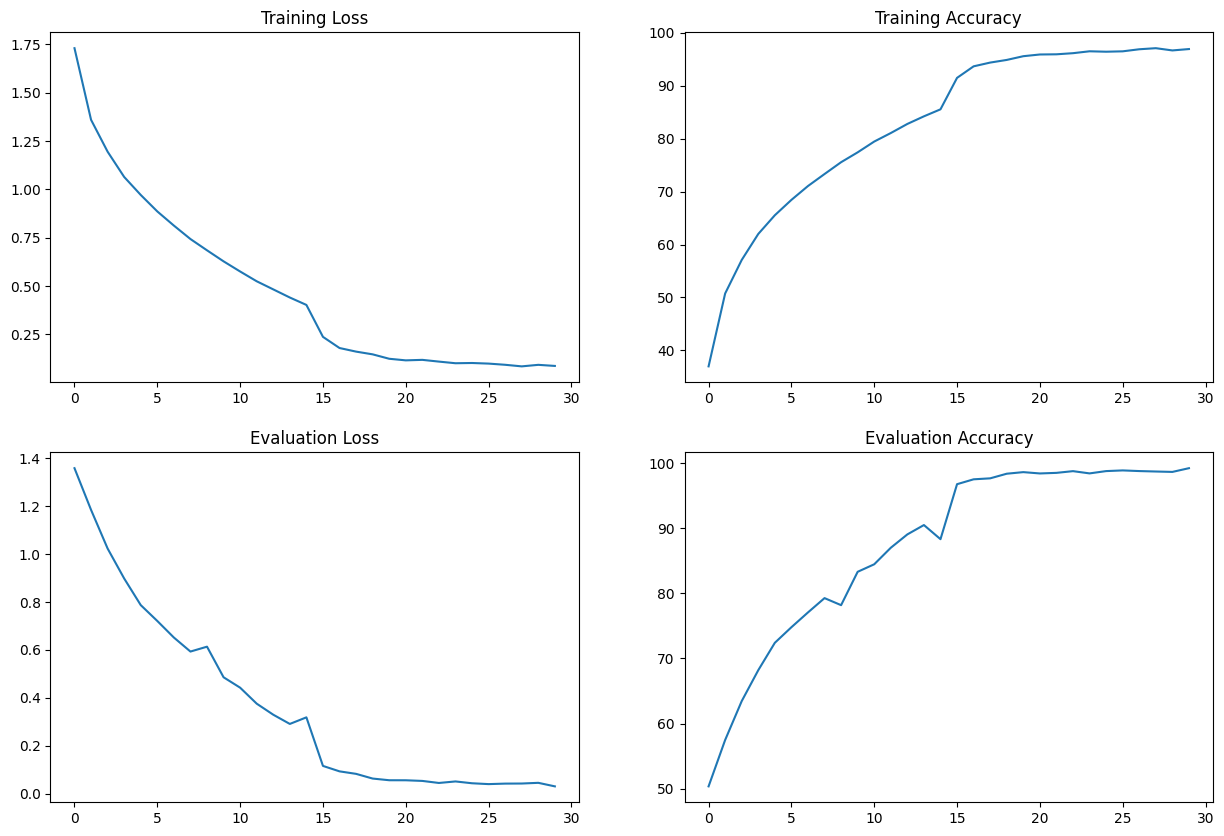

In [44]:
modified_architecture_a = original_architecture[:10]  # using the first 10 layers

modelA = CustomMobileNetV2(
    num_classes=configA["num_classes"],
    inverted_block_configs=modified_architecture_a,
    first_layer_channels=configA["first_layer_channels"],
    expansion_layer_channels=configA["expansion_layer_channels"],
    dropout_rate=configA.get("dropout_rate", 0.0),
    activation=nn.ReLU6 
)

main(modelA, configA, cifar10_dataset, "modelA_exp")

Changing the expansion ratios in the inverted residual blocks.

Train Epoch: 1	Loss: 2.078461, Accuracy: 22.12%
Eval Epoch: 1	Loss: 1.814762, Accuracy: 31.52%
Train Epoch: 2	Loss: 1.768185, Accuracy: 33.74%
Eval Epoch: 2	Loss: 1.645446, Accuracy: 38.72%
Train Epoch: 3	Loss: 1.621687, Accuracy: 39.91%
Eval Epoch: 3	Loss: 1.520575, Accuracy: 43.46%
Train Epoch: 4	Loss: 1.521759, Accuracy: 44.44%
Eval Epoch: 4	Loss: 1.411940, Accuracy: 48.44%
Train Epoch: 5	Loss: 1.433130, Accuracy: 47.78%
Eval Epoch: 5	Loss: 1.313740, Accuracy: 52.75%
Train Epoch: 6	Loss: 1.354636, Accuracy: 51.10%
Eval Epoch: 6	Loss: 1.253762, Accuracy: 55.32%
Train Epoch: 7	Loss: 1.286561, Accuracy: 54.00%
Eval Epoch: 7	Loss: 1.196934, Accuracy: 57.48%
Train Epoch: 8	Loss: 1.219693, Accuracy: 56.40%
Eval Epoch: 8	Loss: 1.102471, Accuracy: 61.21%
Train Epoch: 9	Loss: 1.166397, Accuracy: 58.71%
Eval Epoch: 9	Loss: 1.075077, Accuracy: 61.76%
Train Epoch: 10	Loss: 1.113624, Accuracy: 60.61%
Eval Epoch: 10	Loss: 0.994659, Accuracy: 65.06%
Train Epoch: 11	Loss: 1.070639, Accuracy: 62.08%

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval_accuracy,▁▂▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███████
eval_loss,█▇▇▆▆▅▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
train_accuracy,▁▂▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████████
train_loss,█▇▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,86.41
eval_loss,0.40227
train_accuracy,80.964
train_loss,0.53509


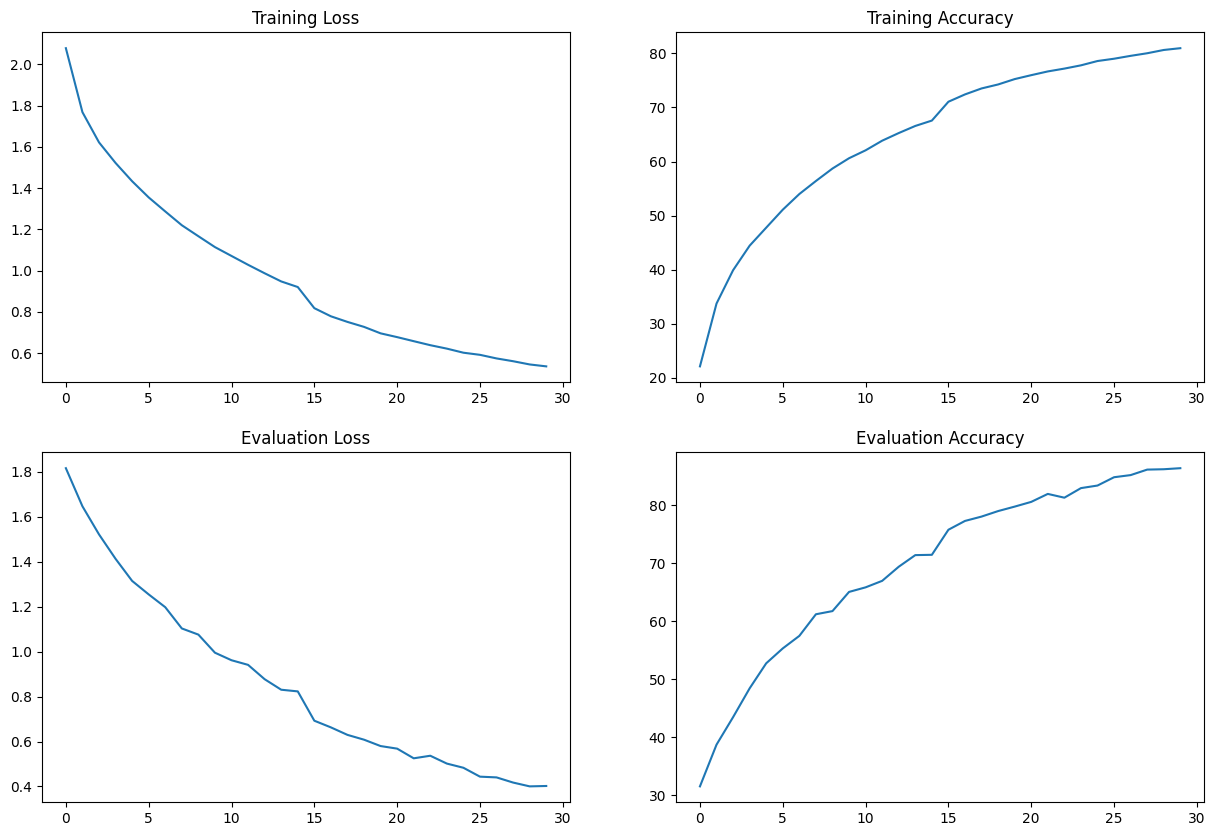

In [45]:
modified_architecture_b = [dict(layer, expand_ratio=2 if layer['expand_ratio'] == 6 else layer['expand_ratio']) for layer in original_architecture]

modelB = CustomMobileNetV2(
    num_classes=configA["num_classes"],
    inverted_block_configs=modified_architecture_b,
    first_layer_channels=configA["first_layer_channels"],
    expansion_layer_channels=configA["expansion_layer_channels"],
    dropout_rate=configA.get("dropout_rate", 0.0),
    activation=nn.ReLU6
)

main(modelB, configA, cifar10_dataset, "modelB_exp")


mps
Train Epoch: 1	Loss: 1.851732, Accuracy: 30.54%
Eval Epoch: 1	Loss: 1.568741, Accuracy: 41.62%
Train Epoch: 2	Loss: 1.515114, Accuracy: 44.93%
Eval Epoch: 2	Loss: 1.325744, Accuracy: 52.43%
Train Epoch: 3	Loss: 1.342955, Accuracy: 51.81%
Eval Epoch: 3	Loss: 1.160341, Accuracy: 59.09%
Train Epoch: 4	Loss: 1.215930, Accuracy: 56.92%
Eval Epoch: 4	Loss: 1.057740, Accuracy: 62.81%
Train Epoch: 5	Loss: 1.102356, Accuracy: 61.08%
Eval Epoch: 5	Loss: 0.982776, Accuracy: 65.13%
Train Epoch: 6	Loss: 1.007009, Accuracy: 65.05%
Eval Epoch: 6	Loss: 0.891105, Accuracy: 68.82%
Train Epoch: 7	Loss: 0.931467, Accuracy: 67.49%
Eval Epoch: 7	Loss: 0.776771, Accuracy: 73.29%
Train Epoch: 8	Loss: 0.858222, Accuracy: 70.26%
Eval Epoch: 8	Loss: 0.696397, Accuracy: 76.50%
Train Epoch: 9	Loss: 0.777416, Accuracy: 73.41%
Eval Epoch: 9	Loss: 0.624585, Accuracy: 79.52%
Train Epoch: 10	Loss: 0.720128, Accuracy: 75.20%
Eval Epoch: 10	Loss: 0.599928, Accuracy: 79.85%
Train Epoch: 11	Loss: 0.671310, Accuracy: 77

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval_accuracy,▁▂▃▄▄▄▅▅▆▆▆▆▆▇▇▇██████████████
eval_loss,█▇▆▆▅▅▄▄▄▄▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇█████████████
train_loss,█▇▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,98.484
eval_loss,0.0498
train_accuracy,96.372
train_loss,0.10573


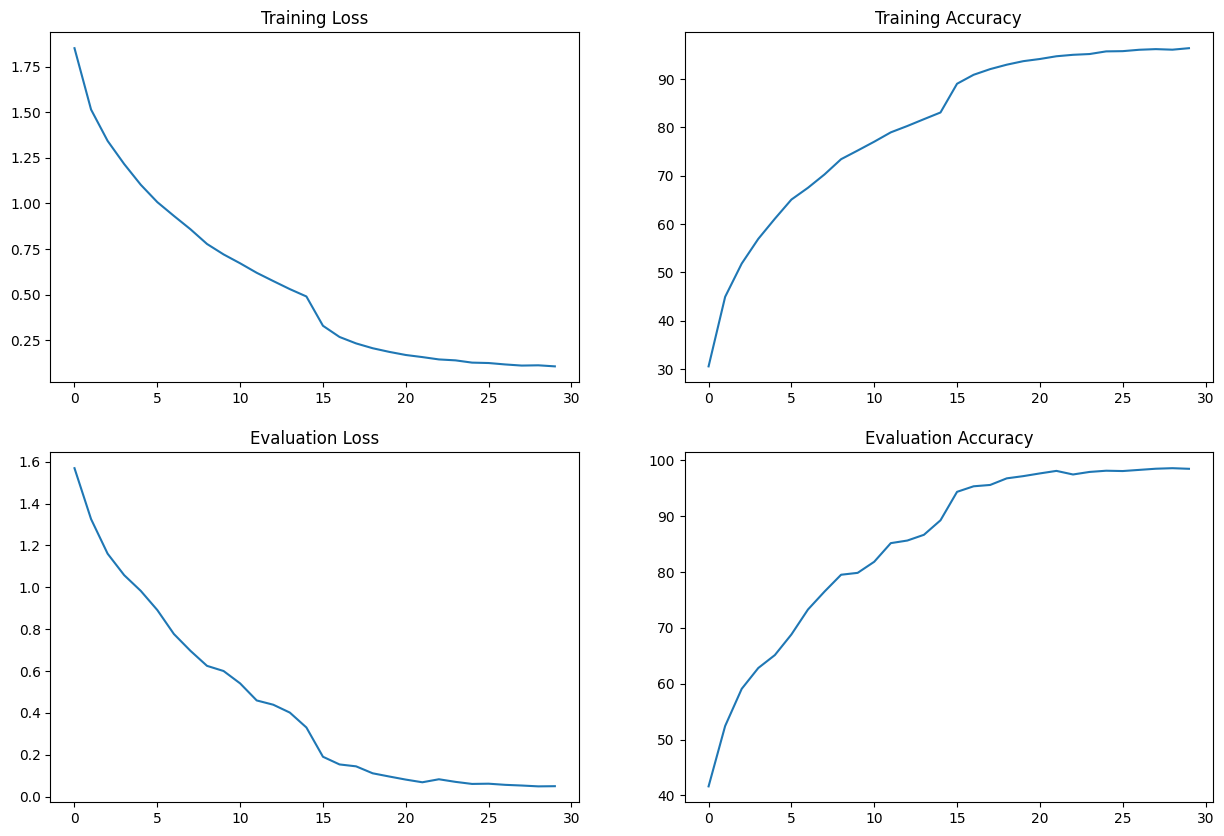

In [52]:
modified_architecture_c = [dict(layer, expand_ratio=10 if layer['expand_ratio'] == 6 else layer['expand_ratio']) for layer in original_architecture]

modelC = CustomMobileNetV2(
    num_classes=configA["num_classes"],
    inverted_block_configs=modified_architecture_c,
    first_layer_channels=configA["first_layer_channels"],
    expansion_layer_channels=configA["expansion_layer_channels"],
    dropout_rate=configA.get("dropout_rate", 0.0),
    activation=nn.ReLU6
)

main(modelC, configA, cifar10_dataset, "modelC_exp")

Trying another activation function, LeakyReLU

mps
Train Epoch: 1	Loss: 1.881783, Accuracy: 29.70%
Eval Epoch: 1	Loss: 1.634105, Accuracy: 39.57%
Train Epoch: 2	Loss: 1.564503, Accuracy: 42.70%
Eval Epoch: 2	Loss: 1.399092, Accuracy: 49.97%
Train Epoch: 3	Loss: 1.411850, Accuracy: 48.86%
Eval Epoch: 3	Loss: 1.241681, Accuracy: 55.67%
Train Epoch: 4	Loss: 1.293237, Accuracy: 53.98%
Eval Epoch: 4	Loss: 1.159577, Accuracy: 58.08%
Train Epoch: 5	Loss: 1.194155, Accuracy: 57.61%
Eval Epoch: 5	Loss: 1.055826, Accuracy: 62.66%
Train Epoch: 6	Loss: 1.102412, Accuracy: 60.87%
Eval Epoch: 6	Loss: 0.977338, Accuracy: 66.03%
Train Epoch: 7	Loss: 1.026709, Accuracy: 64.04%
Eval Epoch: 7	Loss: 0.888523, Accuracy: 69.36%
Train Epoch: 8	Loss: 0.955856, Accuracy: 66.70%
Eval Epoch: 8	Loss: 0.830772, Accuracy: 71.69%
Train Epoch: 9	Loss: 0.891198, Accuracy: 68.76%
Eval Epoch: 9	Loss: 0.758307, Accuracy: 74.08%
Train Epoch: 10	Loss: 0.829404, Accuracy: 71.10%
Eval Epoch: 10	Loss: 0.690072, Accuracy: 76.97%
Train Epoch: 11	Loss: 0.778056, Accuracy: 73

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval_accuracy,▁▂▃▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇████████████
eval_loss,█▇▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▂▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇██████████
train_loss,█▇▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,97.572
eval_loss,0.07938
train_accuracy,94.78
train_loss,0.14957


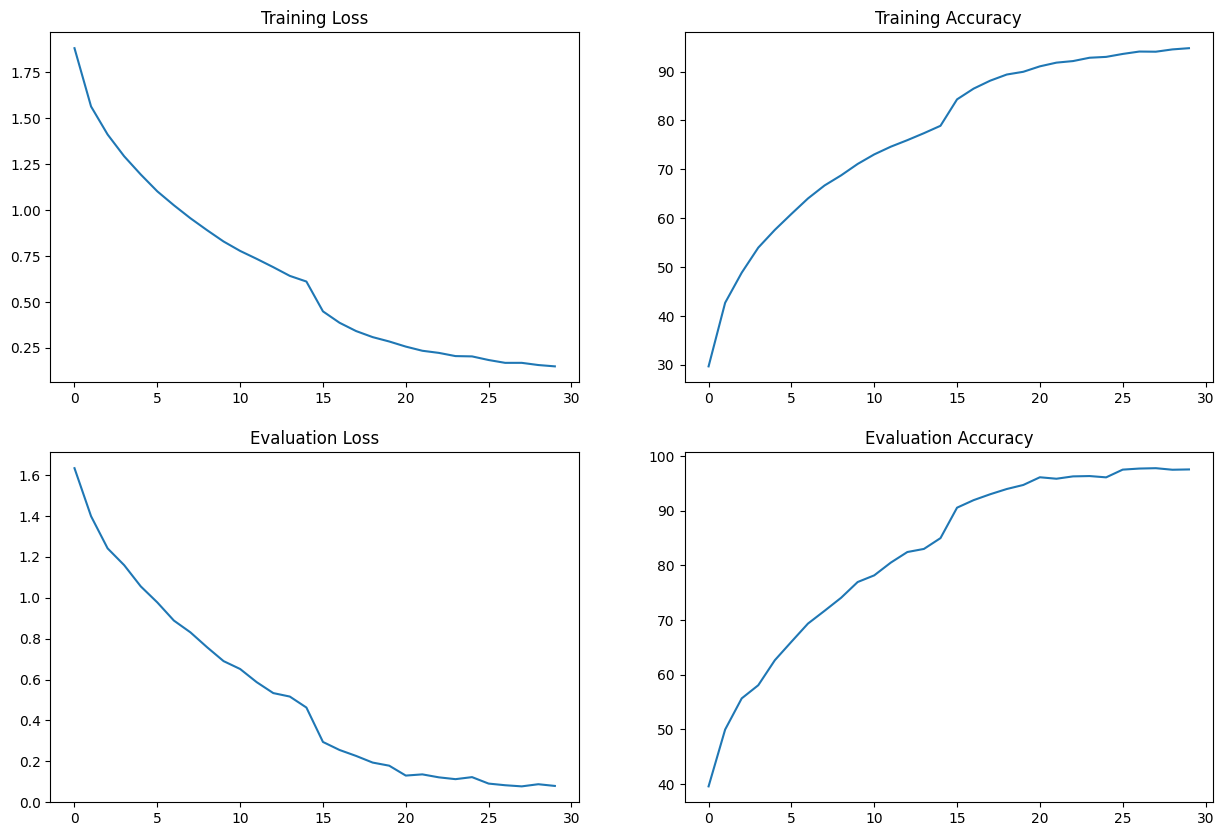

In [74]:
modelLeakyRelu = CustomMobileNetV2(
    num_classes=configA["num_classes"],
    inverted_block_configs=original_architecture,
    first_layer_channels=configA["first_layer_channels"],
    expansion_layer_channels=configA["expansion_layer_channels"],
    dropout_rate=configA.get("dropout_rate", 0.0),
    activation=nn.LeakyReLU
)

main(modelLeakyRelu, configA, cifar10_dataset, "LeakyRelu_exp")


mps
Train Epoch: 1	Loss: 1.744015, Accuracy: 35.54%
Eval Epoch: 1	Loss: 1.452226, Accuracy: 46.39%
Train Epoch: 2	Loss: 1.385844, Accuracy: 49.73%
Eval Epoch: 2	Loss: 1.275620, Accuracy: 54.36%
Train Epoch: 3	Loss: 1.214189, Accuracy: 56.91%
Eval Epoch: 3	Loss: 1.045169, Accuracy: 62.94%
Train Epoch: 4	Loss: 1.086023, Accuracy: 61.74%
Eval Epoch: 4	Loss: 0.936234, Accuracy: 67.81%
Train Epoch: 5	Loss: 0.976584, Accuracy: 65.89%
Eval Epoch: 5	Loss: 0.832313, Accuracy: 71.13%
Train Epoch: 6	Loss: 0.885357, Accuracy: 69.23%
Eval Epoch: 6	Loss: 0.768272, Accuracy: 73.45%
Train Epoch: 7	Loss: 0.804525, Accuracy: 71.88%
Eval Epoch: 7	Loss: 0.672957, Accuracy: 77.35%
Train Epoch: 8	Loss: 0.733342, Accuracy: 74.56%
Eval Epoch: 8	Loss: 0.588649, Accuracy: 80.11%
Train Epoch: 9	Loss: 0.678931, Accuracy: 76.62%
Eval Epoch: 9	Loss: 0.536988, Accuracy: 82.25%
Train Epoch: 10	Loss: 0.623827, Accuracy: 78.16%
Eval Epoch: 10	Loss: 0.490653, Accuracy: 83.77%
Train Epoch: 11	Loss: 0.557613, Accuracy: 80

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval_accuracy,▁▂▃▄▄▅▅▅▆▆▆▆▇▆▇███████████████
eval_loss,█▇▆▅▅▅▄▄▃▃▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇██████████████
train_loss,█▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,99.014
eval_loss,0.03273
train_accuracy,96.988
train_loss,0.0846


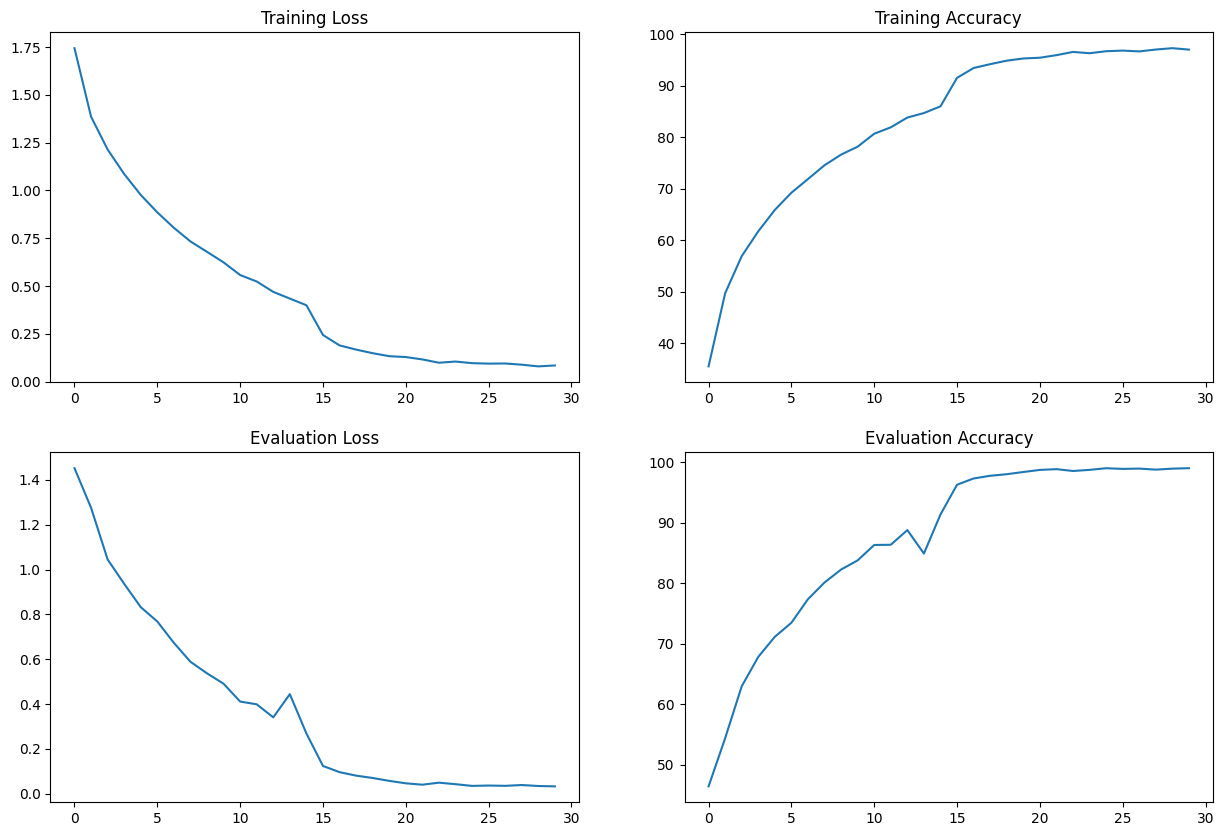

In [49]:
modelSiLU = CustomMobileNetV2(
    num_classes=configA["num_classes"],
    inverted_block_configs=original_architecture,
    first_layer_channels=configA["first_layer_channels"],
    expansion_layer_channels=configA["expansion_layer_channels"],
    dropout_rate=configA.get("dropout_rate", 0.0),
    activation=nn.SiLU
)

main(modelSiLU, configA, cifar10_dataset, "modelSiLU_exp")




mps
Train Epoch: 1	Loss: 1.827432, Accuracy: 31.98%
Eval Epoch: 1	Loss: 1.521163, Accuracy: 42.59%
Train Epoch: 2	Loss: 1.454364, Accuracy: 46.62%
Eval Epoch: 2	Loss: 1.277606, Accuracy: 53.63%
Train Epoch: 3	Loss: 1.275439, Accuracy: 54.19%
Eval Epoch: 3	Loss: 1.103887, Accuracy: 60.40%
Train Epoch: 4	Loss: 1.147977, Accuracy: 58.93%
Eval Epoch: 4	Loss: 1.032052, Accuracy: 62.78%
Train Epoch: 5	Loss: 1.046558, Accuracy: 63.05%
Eval Epoch: 5	Loss: 0.889257, Accuracy: 69.40%
Train Epoch: 6	Loss: 0.951982, Accuracy: 66.48%
Eval Epoch: 6	Loss: 0.781395, Accuracy: 72.68%
Train Epoch: 7	Loss: 0.878985, Accuracy: 69.10%
Eval Epoch: 7	Loss: 0.756083, Accuracy: 74.31%
Train Epoch: 8	Loss: 0.806344, Accuracy: 71.86%
Eval Epoch: 8	Loss: 0.678027, Accuracy: 77.08%
Train Epoch: 9	Loss: 0.753795, Accuracy: 73.77%
Eval Epoch: 9	Loss: 0.568721, Accuracy: 80.69%
Train Epoch: 10	Loss: 0.686342, Accuracy: 75.98%
Eval Epoch: 10	Loss: 0.520599, Accuracy: 82.78%
Train Epoch: 11	Loss: 0.637365, Accuracy: 77

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval_accuracy,▁▂▃▄▄▅▅▅▆▆▆▆▇▇▇███████████████
eval_loss,█▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇█████████████
train_loss,█▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,98.814
eval_loss,0.04066
train_accuracy,96.372
train_loss,0.10244


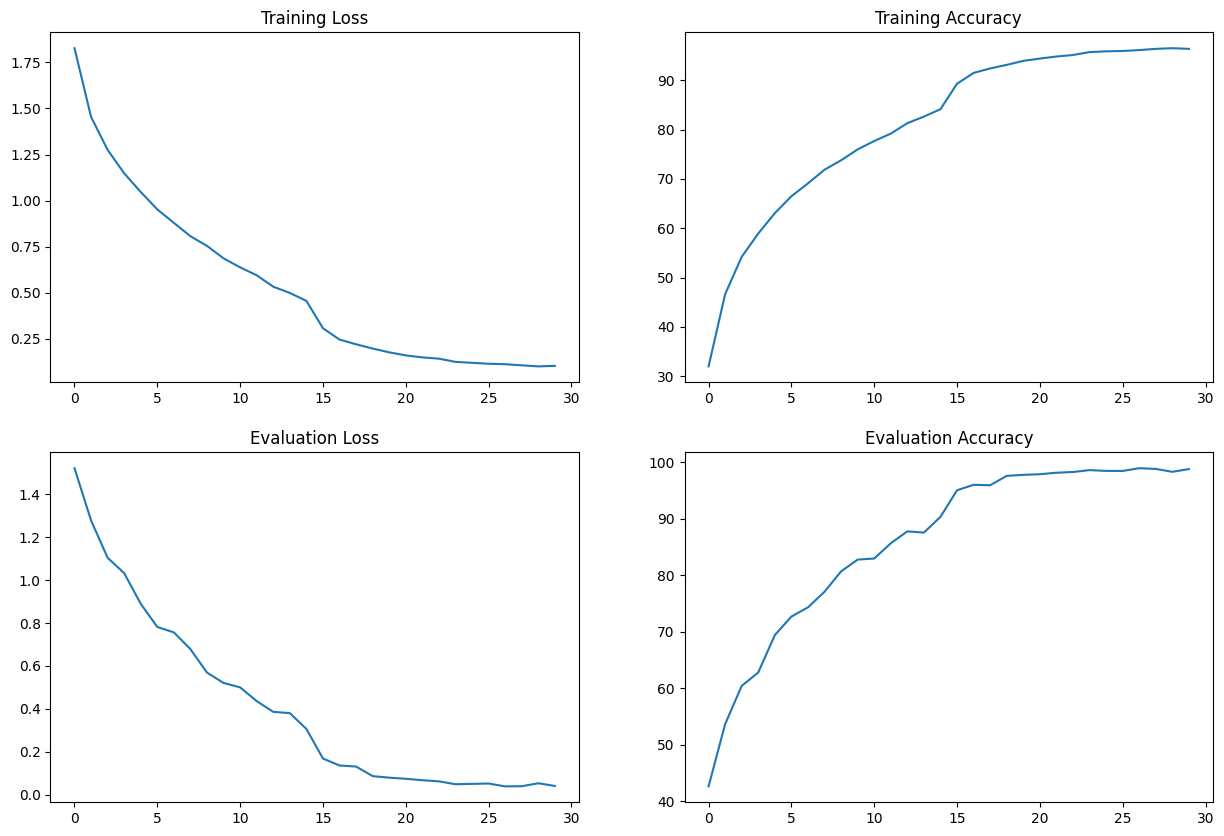

In [50]:
modelHardswish= CustomMobileNetV2(
    num_classes=configA["num_classes"],
    inverted_block_configs=original_architecture,
    first_layer_channels=configA["first_layer_channels"],
    expansion_layer_channels=configA["expansion_layer_channels"],
    dropout_rate=configA.get("dropout_rate", 0.0),
    activation=nn.Hardswish
)

main(modelHardswish, configA, cifar10_dataset, "Hardswish_exp")

mps
Train Epoch: 1	Loss: 1.864698, Accuracy: 31.66%
Eval Epoch: 1	Loss: 1.798830, Accuracy: 33.95%
Train Epoch: 2	Loss: 1.722962, Accuracy: 36.93%
Eval Epoch: 2	Loss: 1.673870, Accuracy: 38.50%
Train Epoch: 3	Loss: 1.608642, Accuracy: 40.51%
Eval Epoch: 3	Loss: 1.585912, Accuracy: 40.14%
Train Epoch: 4	Loss: 1.532299, Accuracy: 43.06%
Eval Epoch: 4	Loss: 1.489674, Accuracy: 45.02%
Train Epoch: 5	Loss: 1.468406, Accuracy: 45.75%
Eval Epoch: 5	Loss: 1.472960, Accuracy: 45.11%
Train Epoch: 6	Loss: 1.410728, Accuracy: 48.16%
Eval Epoch: 6	Loss: 1.389066, Accuracy: 48.99%
Train Epoch: 7	Loss: 1.372530, Accuracy: 49.49%
Eval Epoch: 7	Loss: 1.352957, Accuracy: 49.40%
Train Epoch: 8	Loss: 1.331913, Accuracy: 51.01%
Eval Epoch: 8	Loss: 1.304802, Accuracy: 51.87%
Train Epoch: 9	Loss: 1.299745, Accuracy: 52.41%
Eval Epoch: 9	Loss: 1.240191, Accuracy: 54.41%
Train Epoch: 10	Loss: 1.259082, Accuracy: 53.89%
Eval Epoch: 10	Loss: 1.217261, Accuracy: 55.09%
Train Epoch: 11	Loss: 1.223917, Accuracy: 55

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval_accuracy,▁▂▂▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇██████
eval_loss,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
train_accuracy,▁▂▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████████
train_loss,█▇▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch,30
eval_accuracy,70.432
eval_loss,0.81114
train_accuracy,69.376
train_loss,0.8543


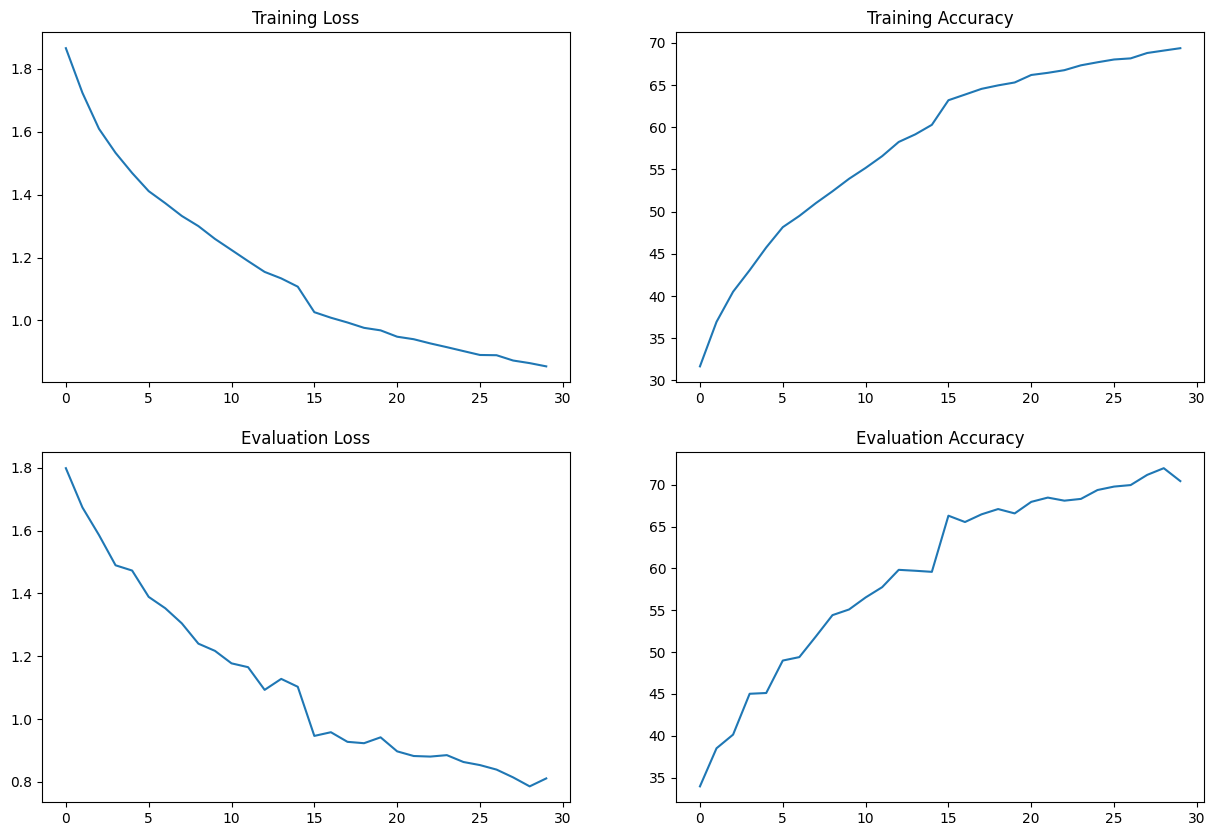

In [51]:
modelHardsigmoid= CustomMobileNetV2(
    num_classes=configA["num_classes"],
    inverted_block_configs=original_architecture,
    first_layer_channels=configA["first_layer_channels"],
    expansion_layer_channels=configA["expansion_layer_channels"],
    dropout_rate=configA.get("dropout_rate", 0.0),
    activation=nn.Hardsigmoid
)

main(modelHardsigmoid, configA, cifar10_dataset, "Hardsigmoid_exp")

mps
Train Epoch: 1	Loss: 1.971579, Accuracy: 26.37%
Eval Epoch: 1	Loss: 1.659416, Accuracy: 38.40%
Train Epoch: 2	Loss: 1.614593, Accuracy: 40.61%
Eval Epoch: 2	Loss: 1.460136, Accuracy: 46.24%
Train Epoch: 3	Loss: 1.450544, Accuracy: 47.32%
Eval Epoch: 3	Loss: 1.363017, Accuracy: 49.18%
Train Epoch: 4	Loss: 1.333105, Accuracy: 52.08%
Eval Epoch: 4	Loss: 1.203909, Accuracy: 55.97%
Train Epoch: 5	Loss: 1.230401, Accuracy: 56.23%
Eval Epoch: 5	Loss: 1.105862, Accuracy: 61.18%
Train Epoch: 6	Loss: 1.147887, Accuracy: 59.32%
Eval Epoch: 6	Loss: 1.013855, Accuracy: 64.38%
Train Epoch: 7	Loss: 1.068427, Accuracy: 62.67%
Eval Epoch: 7	Loss: 1.004955, Accuracy: 65.53%
Train Epoch: 8	Loss: 1.000185, Accuracy: 65.14%
Eval Epoch: 8	Loss: 0.859804, Accuracy: 70.93%
Train Epoch: 9	Loss: 0.934583, Accuracy: 67.12%
Eval Epoch: 9	Loss: 0.825025, Accuracy: 71.73%
Train Epoch: 10	Loss: 0.874641, Accuracy: 69.65%
Eval Epoch: 10	Loss: 0.747997, Accuracy: 74.45%
Train Epoch: 11	Loss: 0.824215, Accuracy: 71

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval_accuracy,▁▂▂▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███████████
eval_loss,█▇▇▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▂▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇██████████
train_loss,█▇▆▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,96.306
eval_loss,0.11459
train_accuracy,93.58
train_loss,0.18533


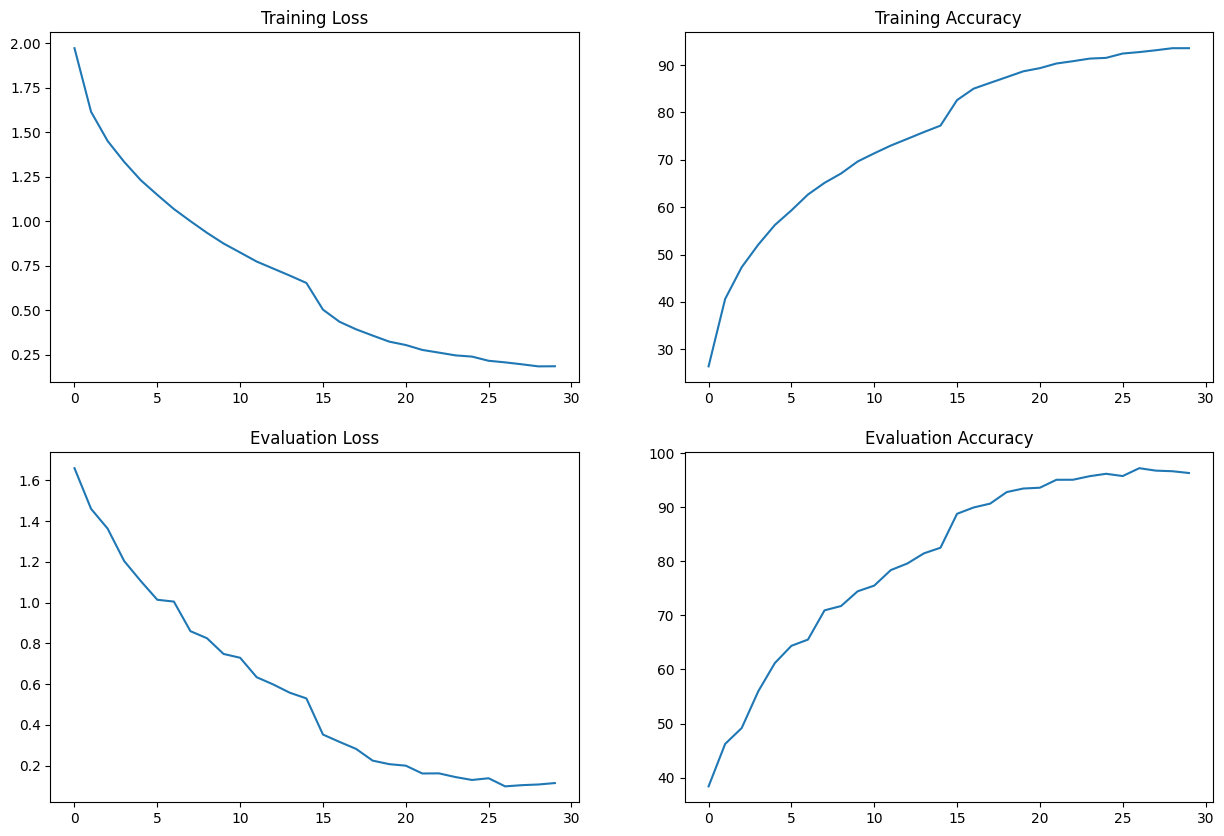

In [75]:
# Using larger kernel size
modified_kernel_size = [dict(layer, kernel_size=5 if layer.get('groups') == layer.get('in_channels') else layer.get('kernel_size', 3)) for layer in original_architecture]


modelD = CustomMobileNetV2(
    num_classes=configA["num_classes"],
    inverted_block_configs=modified_kernel_size,
    first_layer_channels=configA["first_layer_channels"],
    expansion_layer_channels=configA["expansion_layer_channels"],
    dropout_rate=configA.get("dropout_rate", 0.0),
    activation=nn.ReLU6
)


main(modelD, configA, cifar10_dataset, "modelD_exp")

Squeeze-and-Excitation

In [76]:


class SqueezeAndExcitation(nn.Module):
    def __init__(self, input_channels, reduced_dim):
        super(SqueezeAndExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(input_channels, reduced_dim, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduced_dim, input_channels, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return x * self.se(x)

class InvertedResidualkWithSE(nn.Module):
    def __init__(self, inp, outp, stride, expand_ratio, se_ratio=0.25, kernel_size=3, activation=nn.ReLU6):
        super().__init__()
        self.stride = stride
        hidden_dim = int(inp * expand_ratio)
        self.use_shortcut = stride == 1 and inp == outp

        layers = []
        if expand_ratio != 1:
            layers.append(ConvBNActivation(inp, hidden_dim, kernel_size=1, activation=activation))

        layers.append(ConvBNActivation(hidden_dim, hidden_dim, kernel_size=kernel_size, stride=stride, groups=hidden_dim, activation=activation))


        if se_ratio > 0:
            layers.append(SqueezeAndExcitation(hidden_dim, int(hidden_dim * se_ratio)))
        
        self.conv_layers = nn.Sequential(*layers)

        
        self.project_layer = nn.Sequential(
            nn.Conv2d(hidden_dim, outp, 1, 1, 0, bias=False),
            nn.BatchNorm2d(outp)
        )

    def forward(self, x):
        out = self.conv_layers(x)
        out = self.project_layer(out)
        if self.use_shortcut:
            return x + out
        else:
            return out


def forward(self, x):
        out = self.conv_layers(x)
        out = self.project_layer(out)
        if self.use_shortcut:
            return x + out
        else:
            return out

class CustomMobileNetV2SE(nn.Module):
    def __init__(self, num_classes, inverted_block_configs, first_layer_channels, expansion_layer_channels, dropout_rate=0.0, activation=nn.ReLU6):
        super(CustomMobileNetV2SE, self).__init__()

        self.first_layer = ConvBNActivation(3, first_layer_channels, kernel_size=3, stride=2, activation=activation)

        self.inverted_blocks = nn.Sequential(
            *[InvertedResidualkWithSE(cfg["inp"], cfg["outp"], cfg["stride"], cfg["expand_ratio"], activation=activation) for cfg in inverted_block_configs]
        )

        self.expansion_layer = ConvBNActivation(inverted_block_configs[-1]['outp'], expansion_layer_channels, kernel_size=1, activation=activation)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.dropout = nn.Dropout(p=dropout_rate)
        self.classifier = nn.Linear(expansion_layer_channels, num_classes)

        self._initialize_weights()

    def forward(self, x):
        x = self.first_layer(x)
        x = self.inverted_blocks(x)
        x = self.expansion_layer(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)




mps
Train Epoch: 1	Loss: 1.998308, Accuracy: 24.82%
Eval Epoch: 1	Loss: 1.742675, Accuracy: 34.43%
Train Epoch: 2	Loss: 1.634284, Accuracy: 39.73%
Eval Epoch: 2	Loss: 1.477365, Accuracy: 45.34%
Train Epoch: 3	Loss: 1.466531, Accuracy: 46.65%
Eval Epoch: 3	Loss: 1.336755, Accuracy: 51.46%
Train Epoch: 4	Loss: 1.351608, Accuracy: 51.48%
Eval Epoch: 4	Loss: 1.267164, Accuracy: 54.55%
Train Epoch: 5	Loss: 1.251045, Accuracy: 55.30%
Eval Epoch: 5	Loss: 1.096989, Accuracy: 61.40%
Train Epoch: 6	Loss: 1.167441, Accuracy: 58.55%
Eval Epoch: 6	Loss: 1.072861, Accuracy: 62.29%
Train Epoch: 7	Loss: 1.099719, Accuracy: 61.22%
Eval Epoch: 7	Loss: 0.957296, Accuracy: 66.50%
Train Epoch: 8	Loss: 1.030227, Accuracy: 63.73%
Eval Epoch: 8	Loss: 0.931935, Accuracy: 67.33%
Train Epoch: 9	Loss: 0.961668, Accuracy: 66.24%
Eval Epoch: 9	Loss: 0.811931, Accuracy: 71.87%
Train Epoch: 10	Loss: 0.901937, Accuracy: 68.35%
Eval Epoch: 10	Loss: 0.769275, Accuracy: 73.50%
Train Epoch: 11	Loss: 0.847497, Accuracy: 70

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval_accuracy,▁▂▃▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇██████████
eval_loss,█▇▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████████
train_loss,█▇▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,97.976
eval_loss,0.07247
train_accuracy,94.032
train_loss,0.1705


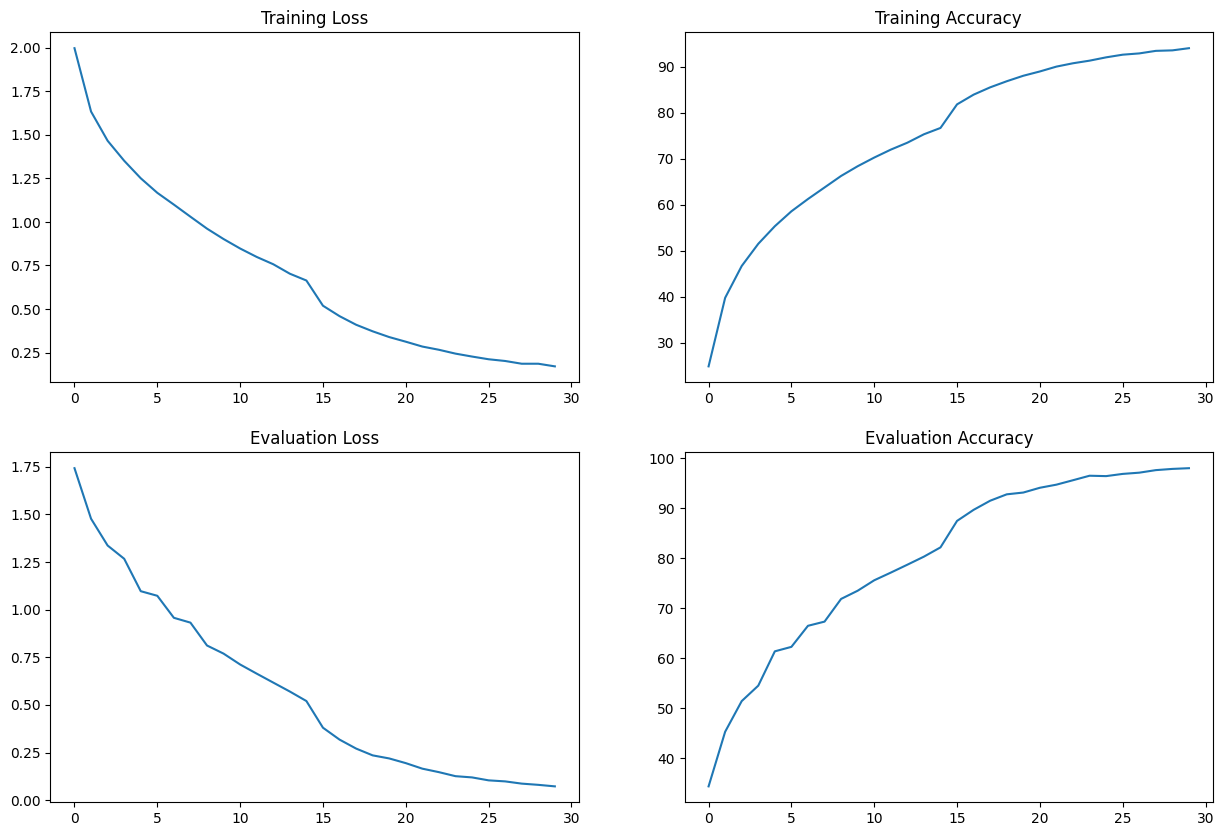

In [81]:
model_with_SE = CustomMobileNetV2SE(
    num_classes=configA["num_classes"],
    inverted_block_configs=original_architecture,
    first_layer_channels=configA["first_layer_channels"],
    expansion_layer_channels=configA["expansion_layer_channels"],
    dropout_rate=configA.get("dropout_rate", 0.0),
    activation=nn.ReLU6
)


main(model_with_SE, configA, cifar10_dataset, "model_SE")